In [1]:
import sys
sys.path.append("..") 

2025-07-30 22:07:05,024 | INFO | Loaded Brent data: 8360 rows.
2025-07-30 22:07:05,027 | INFO | Loaded event data: 14 rows.


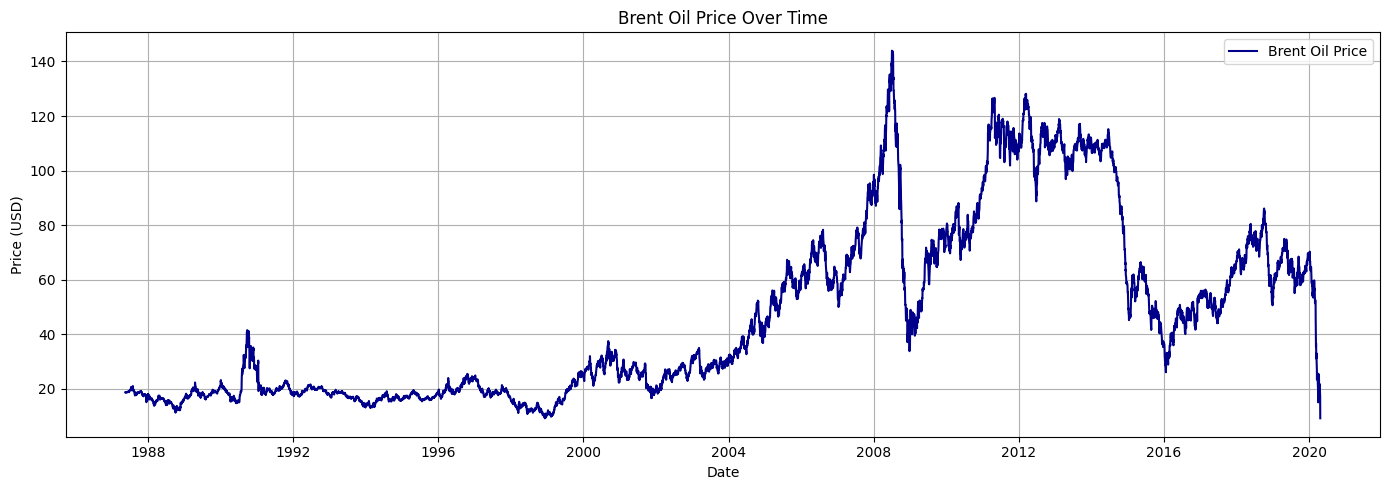

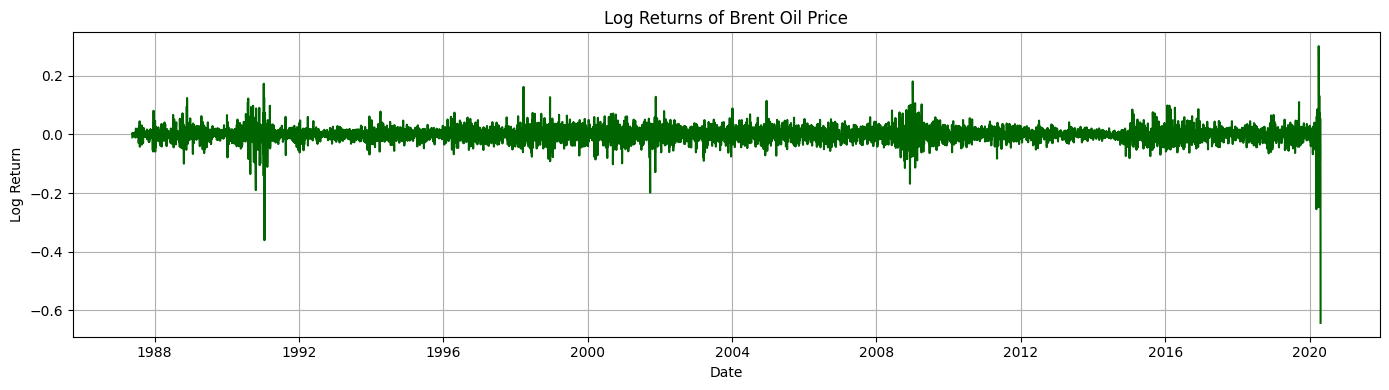

{'ADF Statistic': np.float64(-12.603088598261737),
 'p-value': np.float64(1.719110914309061e-23),
 'Used Lag': 29,
 'Number of Observations': 8329,
 'Critical Values': {'1%': np.float64(-3.431135366372075),
  '5%': np.float64(-2.8618870775509087),
  '10%': np.float64(-2.5669547445378043)},
 'Conclusion': 'Stationary'}

In [2]:
from modules.config import PRICE_FILE, EVENT_FILE
from modules.data_loader import load_brent_data
from modules.event_collector import load_event_data
from modules.eda import plot_price_trend, plot_log_returns
from modules.time_series_utils import compute_log_returns, check_stationarity

df = load_brent_data(PRICE_FILE)
df_events = load_event_data(EVENT_FILE)

plot_price_trend(df)
plot_log_returns(df)

log_df = compute_log_returns(df)
result = check_stationarity(log_df["Log_Return"])
result


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
from modules.config import PRICE_FILE, EVENT_FILE
from modules.data_loader import load_brent_data
from modules.event_collector import load_event_data
from modules.preprocessing import compute_log_returns


In [5]:
from modules.change_point_model import build_change_point_model, sample_model
from modules.insight_generation import associate_event, quantify_impact
from modules.visualization import (
    plot_price_and_log_returns,
    plot_trace_summary,
    plot_tau_posterior,
)

ImportError: cannot import name 'Tester' from 'numpy.testing' (/home/nurye/Desktop/10_Academy/week_10/Change-point-analysis-and-statistical-modelling-of-time-series-data/CPA-venv/lib/python3.10/site-packages/numpy/testing/__init__.py)

In [ ]:

df_prices = load_brent_data(PRICE_FILE)
df_events = load_event_data(EVENT_FILE)

In [ ]:
# Prepare Data
df_prices = compute_log_returns(df_prices)


In [ ]:
# EDA
plot_price_and_log_returns(df_prices)


In [ ]:
# Build & sample Bayesian change point model
model = build_change_point_model(df_prices["Log_Return"].values)
trace = sample_model(model)

In [ ]:
# Diagnostics
plot_trace_summary(trace)


In [ ]:
# Extract & plot change point posterior
change_point_date = plot_tau_posterior(trace, df_prices["Date"].values)
print(f"Most likely change point date detected: {change_point_date.date()}")


In [ ]:
# Associate event
closest_event = associate_event(change_point_date, df_events)
print(f"\nClosest significant event: {closest_event['Event']} on {closest_event['Start_Date']}")


In [ ]:
# Quantify impact
mean_before, mean_after, pct_change = quantify_impact(trace)
print(f"\nMean log return before change: {mean_before:.5f}")
print(f"Mean log return after change: {mean_after:.5f}")
print(f"Percentage change: {pct_change:.2f}%")


In [ ]:
# Summary
print(f"""
Summary:

- Change point date: {change_point_date.date()}
- Closest event: {closest_event['Event']} ({closest_event['Start_Date']})
- Mean log return shifted from {mean_before:.5f} to {mean_after:.5f} ({pct_change:.2f}% change)
""")